In [1]:
import time
import os
import subprocess
import sys
import re
import argparse
import collections
import gzip
import math
import shutil
import matplotlib.pyplot as plt
import wandb
import numpy as np
import time
from datetime import datetime
import random

import seaborn as sns
%matplotlib inline
import logging
from silence_tensorflow import silence_tensorflow
#silence_tensorflow()
#os.environ['TPU_LOAD_LIBRARY']='0'
os.environ['TF_ENABLE_EAGER_CLIENT_STREAMING_ENQUEUE']='False'
import tensorflow as tf


import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
from scipy.stats.stats import spearmanr  
## custom modules
import src.metrics as metrics
from src.optimizers import *
import src.schedulers as schedulers

import training_utils as training_utils

import enformer_vanilla as enformer

from scipy import stats


2023-03-09 17:05:01.672096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 17:05:01.834782: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-09 17:05:01.834812: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-09 17:05:02.713219: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='node-1')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy=\
        tf.data.experimental.AutoShardPolicy.FILE
    options.deterministic=False
    options.experimental_threading.max_intra_op_parallelism=1
    mixed_precision.set_global_policy('mixed_bfloat16')
    #options.num_devices = 64

    BATCH_SIZE_PER_REPLICA = 1 # batch size 24, use LR ~ 2.5 e -04
    NUM_REPLICAS = strategy.num_replicas_in_sync
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * NUM_REPLICAS
    

2023-03-09 17:05:09.485102: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-09 17:05:09.485152: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-09 17:05:09.485176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tpu-genformer-v2-6): /proc/driver/nvidia/version does not exist


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


2023-03-09 17:05:09.852815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
2023-03-09 17:05:09.878346: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:447] Started server with target: grpc://localhost:57629


INFO:tensorflow:Initializing the TPU system: node-1


INFO:tensorflow:Initializing the TPU system: node-1


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
g = tf.random.Generator.from_seed(datetime.now().timestamp())
with strategy.scope():
    tr_data_it,val_data_it,val_data_TSS_it =  \
        training_utils.return_distributed_iterators("gs://picard-testing-176520/enformer_baseline_paired_ATAC_RAMPAGE/tfrecords",
                                                    "gs://picard-testing-176520/enformer_baseline_paired_ATAC_RAMPAGE/tss_sequences/tfrecords",
                                                     GLOBAL_BATCH_SIZE,
                                                     196608,
                                                     10,
                                                     1536,
                                                     62,
                                                     4,
                                                     5,
                                                     strategy,
                                                     options,
                                                    g)

In [4]:
with strategy.scope():
    enformer_model = enformer.Enformer(output_heads_dict = {'human': 62})
    SEQ_LENGTH = 196608
    
    options = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")
    checkpoint = tf.train.Checkpoint(module=enformer_model)#,options=options)
    tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    latest = tf.train.latest_checkpoint("/home/jupyter/dev/BE_CD69_paper_2022/enformer_fine_tuning/checkpoint/sonnet_weights")
    checkpoint.restore(latest,options=options).assert_existing_objects_matched()
    #checkpoint.restore(latest,options=options).assert_consumed()
    

In [5]:
with strategy.scope():        

    optimizer1 = tf.keras.optimizers.Adam(learning_rate=1.0e-04)

    optimizer2 = tf.keras.optimizers.Adam(learning_rate=1.0e-04)
    optimizers_in = optimizer1,optimizer2

    metric_dict = {}

    train_step, val_step, val_step_TSS,build_step, metric_dict = training_utils.return_train_val_functions(enformer_model,
                                                                                                optimizers_in,
                                                                                                strategy,
                                                                                                metric_dict,
                                                                                                400,
                                                                                                100,
                                                                                                100,
                                                                                                GLOBAL_BATCH_SIZE,
                                                                                                0.2)

starting epoch_ 1
loading enformer weights...
completed epoch 1
hg_train_loss: 0.02464033
training duration(mins): 8.921372731526693
val_loss: 0.030141974
pearsonsR: 
0.5546829
R2: 
0.2619613
hg_RNA_pearson_gene: 0.021251222
hg_RNA_R2_gene: [-4.2925816]
returned correlation metrics from make plots function
hg_median_gene_rho_sp_ho: 0.06847011227238649
patience counter at: 0
completed epoch 1 validation
validation duration(mins): 1.3731300870577494
starting epoch_ 2
completed epoch 2
hg_train_loss: 0.0018025477
training duration(mins): 6.797366468111674
val_loss: 0.08996436
pearsonsR: 
0.47555056
R2: 
0.16317917
hg_RNA_pearson_gene: 0.054070964
hg_RNA_R2_gene: [-3.4622526]
returned correlation metrics from make plots function
hg_median_gene_rho_sp_ho: 0.013687948011830826
patience counter at: 0
completed epoch 2 validation
validation duration(mins): 1.3205124576886496
starting epoch_ 3
completed epoch 3
hg_train_loss: 0.0010101816
training duration(mins): 6.792987517515818
val_loss: 0.1

TypeError: early_stopping() got an unexpected keyword argument 'model'

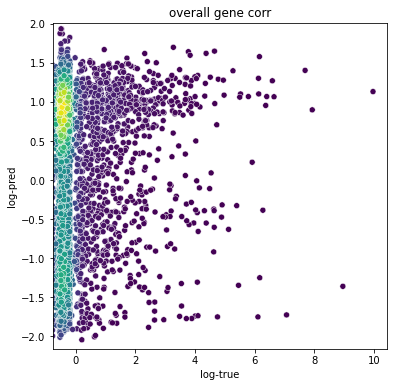

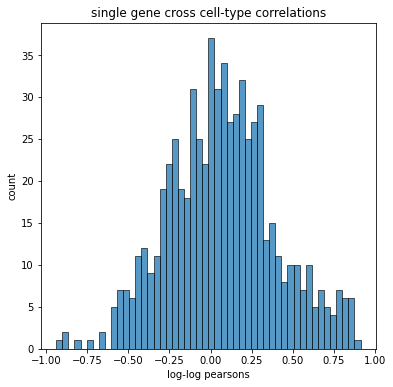

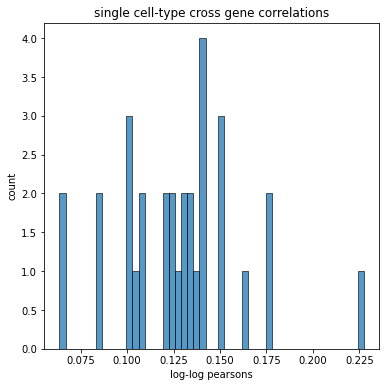

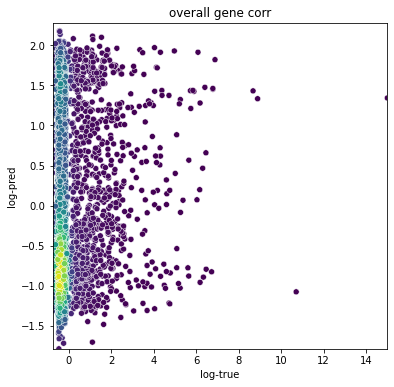

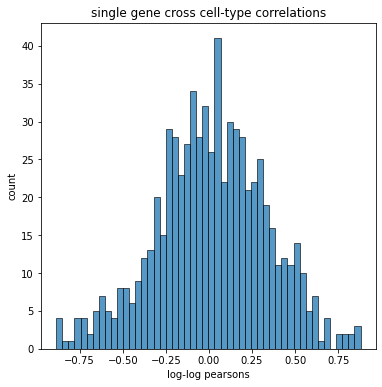

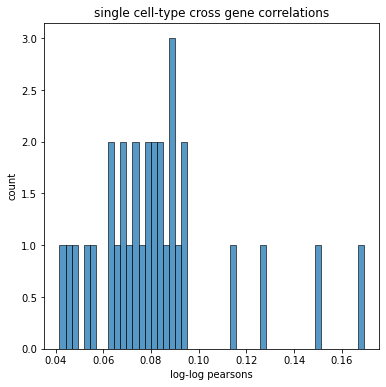

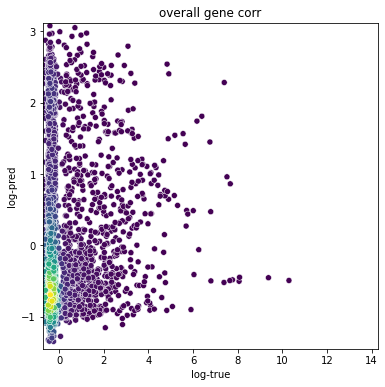

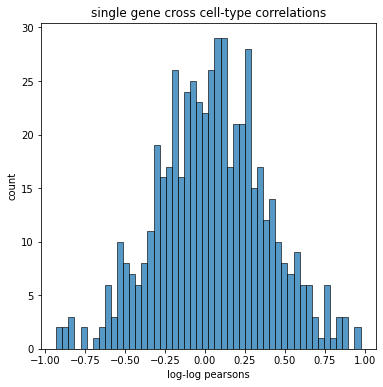

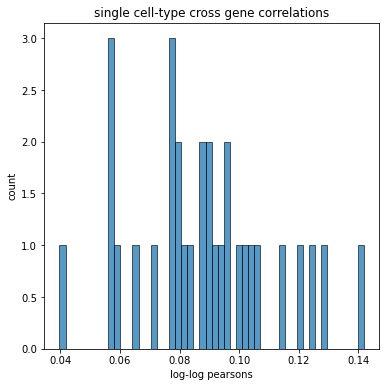

In [6]:
with strategy.scope():        
    ### main training loop
    global_step = 0
    val_losses = []
    val_pearsons = []
    val_R2 = []
    patience_counter = 0
    stop_criteria = False
    best_epoch = 0

    for epoch_i in range(1, 15):
        print('starting epoch_', str(epoch_i))
        start = time.time()
        if epoch_i == 1:
            build_step(val_data_it)
                    
            print('loading enformer weights...')
            options = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")
            checkpoint = tf.train.Checkpoint(module=enformer_model)#,options=options)
            tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
            latest = tf.train.latest_checkpoint("/home/jupyter/dev/BE_CD69_paper_2022/enformer_fine_tuning/checkpoint/sonnet_weights")
            checkpoint.restore(latest,options=options)

        train_step(tr_data_it)

        end = time.time()
        duration = (end - start) / 60.
        print('completed epoch ' + str(epoch_i))
        print('hg_train_loss: ' + str(metric_dict['hg_tr'].result().numpy()))
        
        print('training duration(mins): ' + str(duration))

        start = time.time()
        val_step(val_data_it)

        print('val_loss: ' + str(metric_dict['hg_val'].result().numpy()))
        val_losses.append(metric_dict['hg_val'].result().numpy())

        print('pearsonsR: ')
        pearsonsR=metric_dict['pearsonsR'].result()['PearsonR'].numpy()
        print(np.nanmean(pearsonsR))

        val_pearsons.append(np.nanmedian(pearsonsR))
        print('R2: ')
        print(np.nanmean(metric_dict['R2'].result()['R2'].numpy()))


        val_step_TSS(val_data_TSS_it)
        
        val_pearson = metric_dict['hg_corr_stats'].result()['pearsonR'].numpy()

        print('hg_RNA_pearson_gene: ' + str(val_pearson))
        print('hg_RNA_R2_gene: ' + str(metric_dict['hg_corr_stats'].result()['R2'].numpy()))

        y_trues = np.log(1.0+metric_dict['hg_corr_stats'].result()['y_trues'].numpy())
        y_preds = np.log(metric_dict['hg_corr_stats'].result()['y_preds'].numpy())
        cell_types = metric_dict['hg_corr_stats'].result()['cell_types'].numpy()
        gene_map = metric_dict['hg_corr_stats'].result()['gene_map'].numpy()
        
        
        figures,corrs_overall= training_utils.make_plots(y_trues,y_preds,
                                                         cell_types,gene_map)


        fig_cell_spec, fig_gene_spec, fig_overall=figures 

        cell_spec_corrs,gene_spec_corrs = corrs_overall

        print('returned correlation metrics from make plots function')
        print('hg_median_gene_rho_sp_ho: ' + str(gene_spec_corrs))
        
        if (epoch_i > 2):
            stop_criteria,patience_counter,best_epoch = \
                training_utils.early_stopping(current_val_loss=val_losses[-1],
                                                logged_val_losses=val_losses,
                                                current_pearsons=val_pearsons[-1],
                                                logged_pearsons=val_pearsons,
                                                current_epoch=epoch_i,
                                                best_epoch=best_epoch,
                                                save_freq=5,
                                                patience=5,
                                                patience_counter=patience_counter,
                                                min_delta=1.0e-05,
                                                model=enformer_model,
                                                save_directory="gs://picard-testing-176520/test",
                                                saved_model_basename="test_model",
                                                checkpoint=checkpoint)
        #plt.close('all')
        print('patience counter at: ' + str(patience_counter))
        end = time.time()
        duration = (end - start) / 60.
        print('completed epoch ' + str(epoch_i) + ' validation')
        print('validation duration(mins): ' + str(duration))
        for key, item in metric_dict.items():
            item.reset_state()

In [ ]:
next(val_data_TSS_it)

In [10]:
target=tf.cast(test['target'].values[0][0],dtype=tf.bfloat16)

In [11]:
mask = tf.cast(test['tss_mask'].values[0][0][:,0],dtype=tf.int32)
indices=tf.where(mask > 0)


In [14]:
test['gene_name'].values[0]

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 2482,  5402, 15816], dtype=int32)>

In [8]:
test=tf.constant(0)
test

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [11]:
tf.tile(tf.expand_dims(test,axis=0),[49])

<tf.Tensor: shape=(49,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0], dtype=int32)>

In [15]:
tf.ensure_shape(tf.range(0,49),[49,])

<tf.Tensor: shape=(49,), dtype=int32, numpy=
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
      dtype=int32)>

TypeError: 'dict_values' object is not subscriptable

In [17]:
import pandas as pd
import numpy as np

In [20]:
test = [1,2,3,4,5,6,7,8,9,10,11,12]
test1=[1,2,1,2,1,2,1,2,1,2,1,2]


test_z_score = (test - np.mean(test)) / np.std(test)
test1_z_score = (test1 - np.mean(test1)) / np.std(test1)

In [14]:
from scipy.stats.stats import pearsonr


In [21]:
pearsonr(test_z_score,test1_z_score)

(0.14484136487558025, 0.6533385771243545)

In [22]:
pearsonr(test,test1)

(0.14484136487558028, 0.6533385771243545)

In [17]:
y_true = [[0., 1.], [0., 0.]]
y_pred = [[1., 1.], [0., 0.]]
p=tf.keras.losses.Poisson()
p(y_true,y_pred).numpy()

0.49999997